In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

In [21]:
import numpy as np
import pandas as pd
import yfinance as yf

In [22]:
path = './data/'
data = pd.read_csv(path +'Cart_IBrA.csv' , sep=';' )['Código']
tickers = list(data.values+'.SA')
tickers.remove('BRAV3.SA')

In [23]:
price = yf.download( tickers =  tickers, period='2y' , auto_adjust=True )['Close'].dropna()
price.columns = price.columns.str.replace(r'\.SA$', '', regex=True)
data_pc = price.pct_change()
data_pc.tail(2)

[*********************100%%**********************]  177 of 177 completed


Ticker,ABCB4,ABEV3,AERI3,AESB3,AGRO3,ALOS3,ALPA4,ALUP11,AMBP3,ANIM3,...,VBBR3,VIVA3,VIVT3,VLID3,VULC3,VVEO3,WEGE3,WIZC3,YDUQ3,ZAMP3
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-29,-0.009403,0.006982,-0.025000,-0.002273,-0.001694,-0.004968,-0.009722,-0.007506,-0.018580,-0.049057,...,-0.005822,-0.008327,-0.036205,-0.016803,0.000000,-0.019900,0.012087,-0.011986,-0.021237,-0.035573
2024-10-30,0.002373,-0.003852,0.009615,-0.066059,0.005513,0.004539,0.016830,0.008938,0.037017,0.035714,...,0.004955,0.025590,0.014833,0.035933,0.020859,0.050761,-0.051633,0.012132,0.023585,-0.004098


In [24]:
data_std = data_pc.std()*(252**0.5)*100
data_std.tail()

Ticker
VVEO3    70.778870
WEGE3    27.101534
WIZC3    35.966524
YDUQ3    49.277732
ZAMP3    56.438154
dtype: float64

#### decis de volatilidade

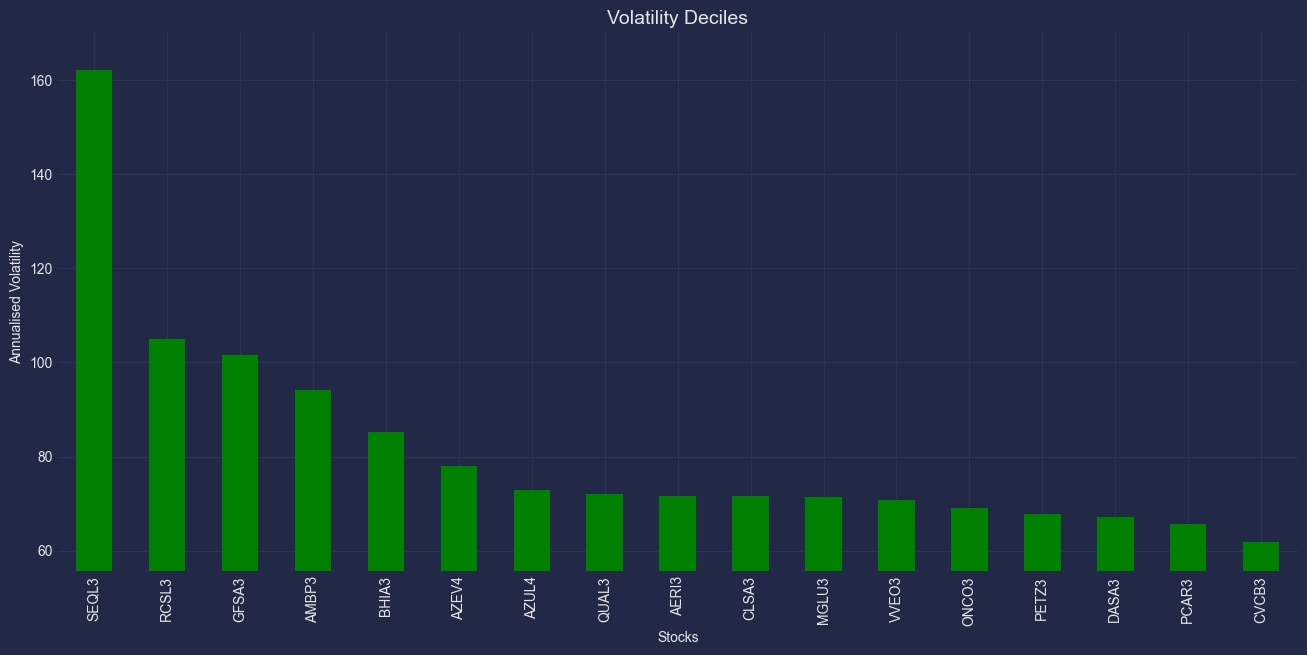

In [25]:
vol_sorted = data_std.sort_values(ascending=False)
top_decile = vol_sorted[:int(len(data_std)*0.1)]
top_decile.plot.bar(figsize=(16,7),color='green',ylim=top_decile.min()*0.9)
plt.title('Volatility Deciles', fontsize=14)
plt.xlabel('Stocks')
plt.ylabel('Annualised Volatility')
plt.show()

In [26]:
stock_data = price.loc[:,top_decile.index]
stock_data_pc = stock_data.pct_change()

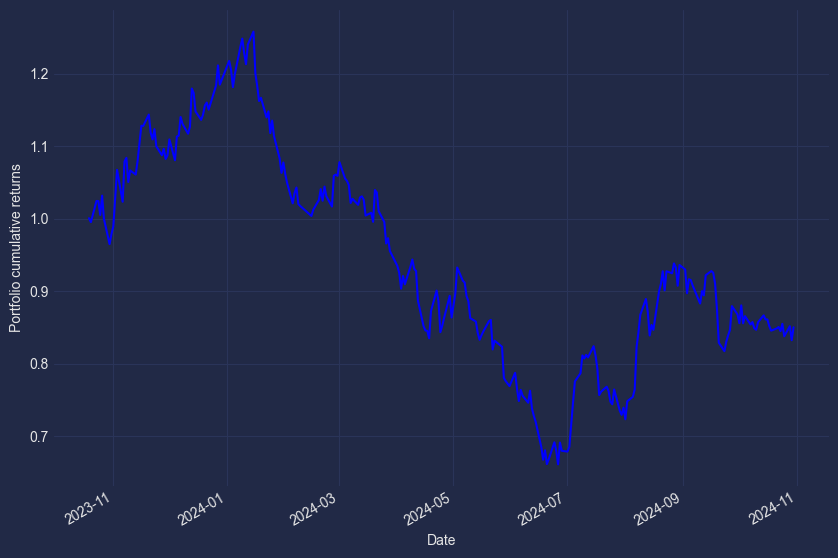

In [27]:
portfolio = pd.DataFrame()
portfolio['returns'] = stock_data_pc.mean(axis=1)
portfolio['cumreturn'] = (portfolio+1).cumprod()
portfolio = portfolio.dropna()
portfolio.cumreturn.plot(color='b',figsize=(10,7))
plt.ylabel("Portfolio cumulative returns")
plt.show()

<a id='analyse_SMA'></a>
##### Sinal de Trading baseado em Médias Móveis
1. média móvel simples de 10 dia
2. sinal 1 quando o valor da carteira for maior do que a média móvel simples.

 A linha azul indica o retorno acumulado
 A linha amarela o sinal.
 A área sombreada o período em que estamos comprados


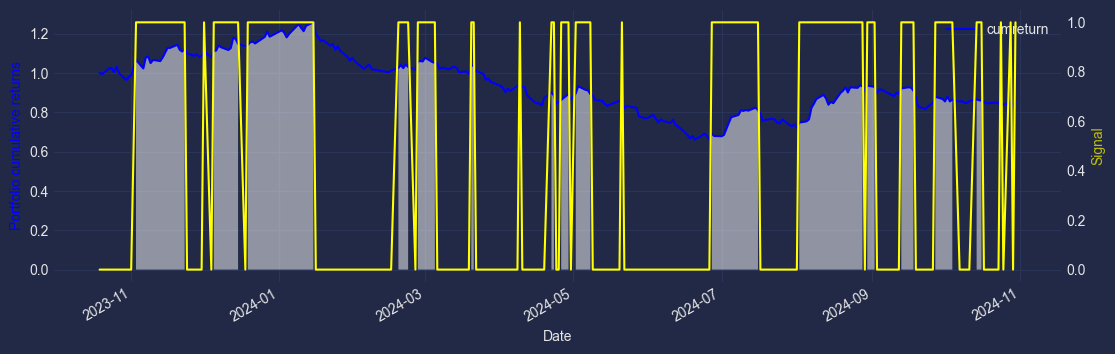

In [28]:
def get_strategy_returns_sma(portfolio):
    # média móvel simples do período 10
    portfolio['sma10'] = portfolio.cumreturn.rolling(window=10).mean()
    # sinal de trading
    portfolio['signal'] = np.where(portfolio.cumreturn > portfolio.sma10,1,0)
    # retornos da estratégia
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    return portfolio

def plot_signal(portfolio):
    portfolio['cumreturn'].plot(color='blue')    
    plt.fill_between(portfolio.index, portfolio.cumreturn, where=(portfolio.signal==1), facecolor='w', alpha=0.5)      
    plt.legend()
    plt.ylabel('Portfolio cumulative returns',color='b')
    # Plote os valores do sinal    
    portfolio['signal'].plot(secondary_y=True,figsize=(13,4),color='yellow')
    plt.ylabel('Signal',color='y')
    plt.show()


print(' A linha azul indica o retorno acumulado\n A linha amarela o sinal.\n A área sombreada o período em que estamos comprados')
portfolio = get_strategy_returns_sma(portfolio)    
plot_signal(portfolio)    

O Sharpe ratio é 0.25 


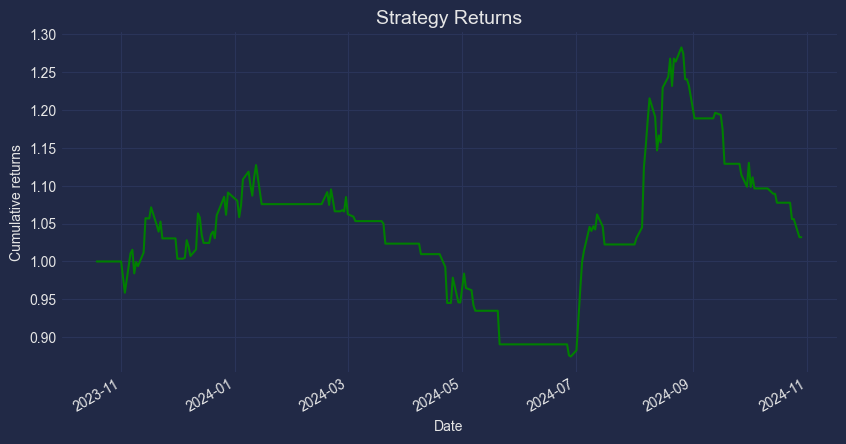

O drawdonw máximo é -22.41


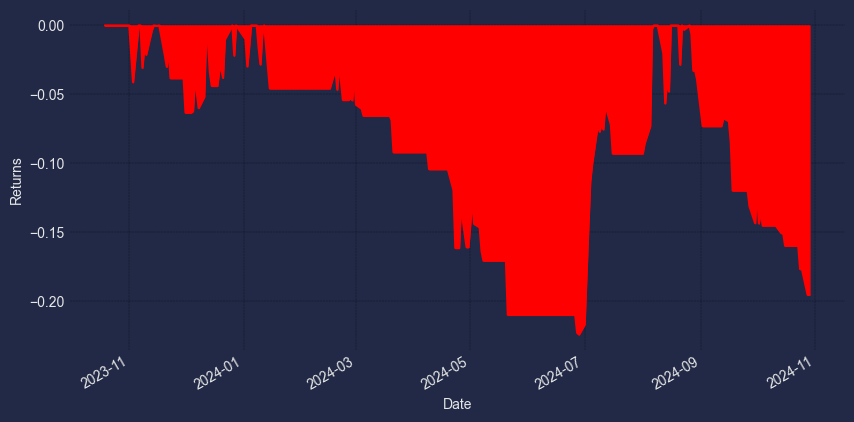

In [29]:
# Plote os retornos do portfolio
def plot_returns_dd(portfolio):
    # ----------- Índice de Sharpe ------------------
    sharpe_ratio = np.mean(portfolio.str_returns)/np.std(portfolio.str_returns)*(252**0.5)
    print('O Sharpe ratio é %.2f ' % sharpe_ratio)

    # ----------- Retornos Cumulatvos da Estratégia ------------------
    portfolio['cum_str_returns'] = (portfolio['str_returns']+1).cumprod()
    portfolio['cum_str_returns'].plot(figsize=(10,5), color='green')
    plt.title('Strategy Returns', fontsize=14)
    plt.ylabel('Cumulative returns')
    plt.show()        

    # ----------- Drawdown ------------------    
    # Calcule o máximo de execução
    running_max = np.maximum.accumulate(portfolio['cum_str_returns'].dropna())
    running_max[running_max < 1] = 1
    # Calcule a porcentagem do drawdown
    drawdown = (portfolio['cum_str_returns'])/running_max - 1
    max_dd = drawdown.min()*100
    print('O drawdonw máximo é %.2f' % max_dd)
    # Plote drawdowns
    drawdown.plot(color='r',figsize=(10,5))
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()    
    
plot_returns_dd(portfolio)    

##### Sinais de negociação: breakout

1. *Breakout*: valor máximo da carteira dos dois dias anteriores.
2. *Sinal de negociação*: 1 quando o valor da carteira do dia atual for maior que o valor máximo calculado na etapa 1.

O Sharpe ratio é -0.02 


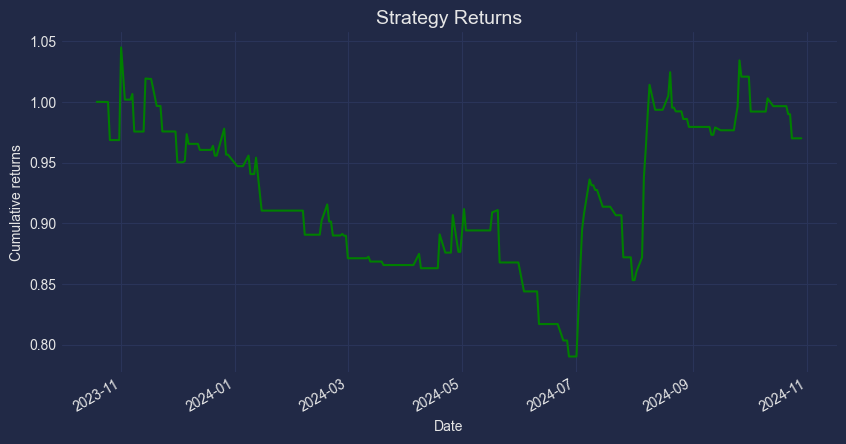

O drawdonw máximo é -24.37


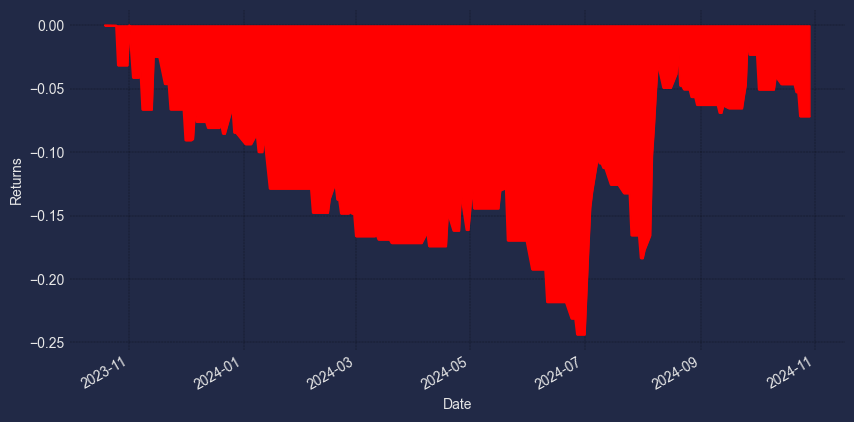

In [30]:
def get_strategy_returns_breakout(portfolio):
    # Calcule os valores do indicador de breakout
    portfolio['high'] = portfolio.cumreturn.rolling(window=3).max()
    # Crie um sinal de trading
    portfolio['signal'] = np.where(portfolio.cumreturn>=portfolio.high,1,0)
    # Calcule os retornos da estratégia
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    return portfolio

portfolio = get_strategy_returns_breakout(portfolio)
#plot_signal(portfolio)    
plot_returns_dd(portfolio)    

In [31]:
portfolio.tail(20)

,returns,cumreturn,sma10,signal,str_returns,cum_str_returns,high
Date,,,,,,,
2024-10-03,-0.028166,0.855692,0.850242,0,0.000000,0.992008,0.880491
2024-10-04,0.011605,0.865622,0.853914,0,-0.000000,0.992008,0.880491
2024-10-07,-0.013279,0.854127,0.857593,0,0.000000,0.992008,0.865622
2024-10-08,0.003882,0.857443,0.860289,0,-0.000000,0.992008,0.865622
2024-10-09,-0.010149,0.848741,0.861246,0,-0.000000,0.992008,0.857443
2024-10-10,-0.002228,0.846850,0.861235,0,0.000000,0.992008,0.857443
2024-10-11,0.012346,0.857305,0.859018,1,0.010990,1.002910,0.857305
2024-10-14,0.010990,0.866727,0.858886,1,-0.006428,0.996463,0.866727
2024-10-15,-0.006428,0.861156,0.859416,0,-0.000000,0.996463,0.866727


#### Sinais de negociação  média móvel e breakout

O Sharpe ratio é -0.07 


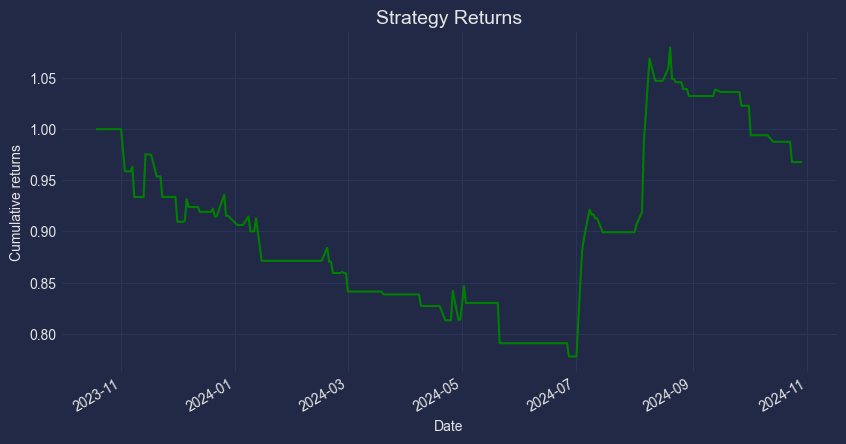

O drawdonw máximo é -22.22


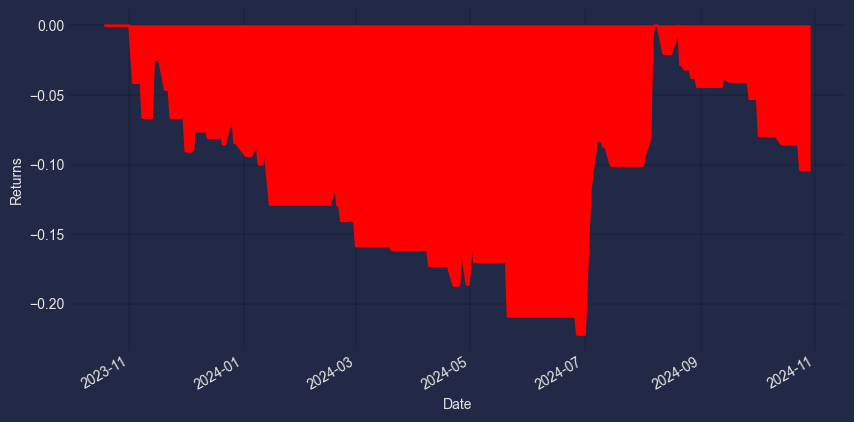

In [32]:
def get_strategy_returns_sma_breakout(portfolio):
    # Calcule a média móvel simples
    sma10 = portfolio.cumreturn > portfolio.cumreturn.rolling(window=10).mean()
    # Calcule os valores do indicador de breakout
    breakout = portfolio.cumreturn>=portfolio.cumreturn.rolling(window=3).max()

    # Crie um sinal de trading
    portfolio['signal'] = np.where(sma10 & breakout,1,0)

    # Calcule os retornos da estratégia
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    return portfolio

portfolio = get_strategy_returns_sma_breakout(portfolio)
#plot_signal(portfolio)    
plot_returns_dd(portfolio)    